This notebook implements a Wide-Deep Model, which simulataneously uses a wide linear model along with a deep learning model to predict the ratings. 

# Import Packages & Directory

In [ ]:
from keras.layers import Input, Embedding, Dense, Concatenate, Flatten, GlobalAveragePooling1D, GlobalMaxPooling1D 
from keras.models import Model
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam, SGD
from keras.callbacks import LearningRateScheduler
import tensorflow as tf
from keras import regularizers

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
%cd 'drive/MyDrive/DSA4212/'

/content/drive/MyDrive/DSA4212


# Read and Preprocess Data

Load the dataset, shuffle and split into training and and validation sets. 

In [ ]:
# Load data
train_ds = pd.read_csv('assignment_2_ratings_train.csv')

In [ ]:
#Shuffle and Split
train_all_shuffled = train_ds.sample(frac = 1)
train, valid = train_test_split(train_all_shuffled, test_size=0.2)

In [ ]:
#Store the number of unique users and movies 
num_users = train['user_id'].nunique()
num_movies = train['anime_id'].nunique()

# Build Model

The wide deep model is built as follows 

In [ ]:
# Define input layers
user_id_input = Input(shape=(1,), name='user_id')
movie_id_input = Input(shape=(1,), name='movie_id')

# Define embedding layers for user ID and movie ID
user_embedding = Embedding(input_dim=num_users, output_dim=50, name='user_embedding')(user_id_input)
movie_embedding = Embedding(input_dim=num_movies, output_dim=50, name='movie_embedding')(movie_id_input)

# Flatten embeddings
user_flatten = Flatten()(user_embedding)
movie_flatten = Flatten()(movie_embedding)

# Wide: concatenated user ID and movie ID features
wide = Concatenate(name='wide_concat')([user_flatten, movie_flatten])

# Deep: Fully connected layers 
deep = Dense(2048, activation='relu', name='deep_1')(Concatenate()([user_embedding, movie_embedding]))
#note that the following layers were added and tested out as well as a part of the fine tuning process 
#deep = Dense(10, activation='relu', name='deep_2')(deep)
#deep = Dense(64, activation='relu', name='deep_3')(deep)
deep = Flatten()(deep)

# Concatenate wide and deep parts
wide_deep = Concatenate(name='wide_deep_concat')([wide, deep])

# Output: predict with a linear activation 
output = Dense(1, activation='linear', name='output')(wide_deep)

# Define model with input and output layers
model = Model(inputs=[user_id_input, movie_id_input], outputs=output)

A learning rate decay schedule is defined with the following function 

In [ ]:
def exp_decay(epoch, lr):
    #no decay until 5 epochs
    if epoch <5: 
      return lr
    #exponentila decay after 5 epochs at rate of 0.1
    else:
      return lr * tf.math.exp(-0.1)
lrate = LearningRateScheduler(exp_decay)

In [ ]:
#Compile model with Adam optimizer and MSE as the main metric/Loss
model.compile(loss='mean_squared_error', optimizer= Adam(learning_rate = 0.001), metrics=['mse'])

# Train model with validation set
history = model.fit(
    x=[train['user_id'], train['anime_id']],
    y=train['rating'],
    validation_data=([valid['user_id'], valid['anime_id']], valid['rating']),
    batch_size=4096,
    epochs=10,
    callbacks = [lrate]
)

Epoch 1/10
867/867 [==============================] - 19s 19ms/step - loss: 3.7755 - mse: 3.7755 - val_loss: 1.6890 - val_mse: 1.6890 - lr: 0.0010
Epoch 2/10
867/867 [==============================] - 13s 15ms/step - loss: 1.6529 - mse: 1.6529 - val_loss: 1.6479 - val_mse: 1.6479 - lr: 0.0010
Epoch 3/10
867/867 [==============================] - 9s 11ms/step - loss: 1.6117 - mse: 1.6117 - val_loss: 1.6328 - val_mse: 1.6328 - lr: 0.0010
Epoch 4/10
867/867 [==============================] - 9s 10ms/step - loss: 1.5859 - mse: 1.5859 - val_loss: 1.6211 - val_mse: 1.6211 - lr: 0.0010
Epoch 5/10
867/867 [==============================] - 10s 11ms/step - loss: 1.5515 - mse: 1.5515 - val_loss: 1.6108 - val_mse: 1.6108 - lr: 0.0010
Epoch 6/10
867/867 [==============================] - 10s 11ms/step - loss: 1.5119 - mse: 1.5119 - val_loss: 1.5966 - val_mse: 1.5966 - lr: 9.0484e-04
Epoch 7/10
867/867 [==============================] - 9s 11ms/step - loss: 1.4755 - mse: 1.4755 - val_loss: 1.5931 -

#Evaluation

Plot the training and validation MSE

In [ ]:
import matplotlib.pyplot as plt

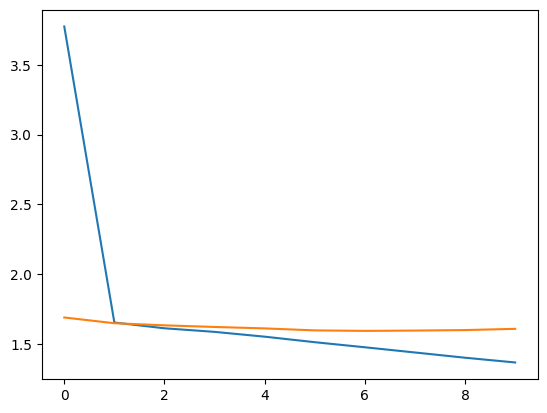

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

Evaluate the model on the validation dataset 

In [ ]:
valid_predictions = model.predict([valid['user_id'], valid['anime_id']])

59412/59412 [==============================] - 135s 2ms/step


In [ ]:
model.evaluate([valid['user_id'], valid['anime_id']], valid['rating'])

59412/59412 [==============================] - 168s 3ms/step - loss: 1.6076 - mse: 1.6076


[1.6075901985168457, 1.6075901985168457]